## **Nigeria flooding study**

In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

---
### **Define catchments**

In [ ]:
# Lake Chad catchment
gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev03").to_crs(epsg = "4326").iloc[[39]].to_file("00_regions/sf_lake-chad")

# Region around Lagdo Dam
gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev05").loc[[407]].to_crs(epsg = "4326").to_file("00_regions/sf_lagdo-dam")

# Lower Niger
states = gpd.read_file("00_regions/nigeria-lgas").to_crs(epsg = "4326")
nb = gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev03").to_crs(epsg = "4326").iloc[[16]]
pd.concat([nb.clip(states), gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev04").loc[[93,98]]]).dissolve().to_file("00_regions/sf_lower-niger")

In [4]:
# extract lat & lon, save as points for easier upload to Climate Explorer
for fnm in ["sf_lower-niger", "sf_lake-chad", "sf_lagdo-dam"]:
    
    gdf = gpd.read_file("00_regions/"+fnm)
    px = gdf.geometry[0].exterior.coords.xy
    pd.DataFrame(px, index = ["#lon", "lat"]).transpose().to_csv("00_regions/"+fnm+"_latlon.txt", index = None, sep = " ")

In [5]:
# also list affected states (mentioned in news stories in )
aff = ['Abia', 'Adamawa', 'Anambra', 'Bauchi', 'Bayelsa', 'Benue', 'Borno', 'Cross River', 'Delta', 'Ebonyi', 'Edo', 'Gombe',
        'Imo', 'Jigawa', 'Kano', 'Kebbi', 'Kogi', 'Lagos', 'Niger', 'Plateau', 'Rivers', 'Sokoto', 'Taraba', 'Yobe', 'Zamfara']
states = gpd.read_file("00_regions/nigeria-lgas")
states = states.loc[[s in aff for s in states.STATE]].dissolve("STATE")
states.to_file("00_regions/sf_affected-states")

### **Comparison of timescales**

In [38]:
pr_ln = xr.open_dataset("obs/chirps_lower-niger_daily.nc").precip

In [ ]:
labelticks = [i for i in range(366) if pr.sel(time = slice("20180101", "20190101")).time.dt.day[i] == 1]
labels = [pr.sel(time = slice("20180101", "20190101")).time[i].values for i in range(366) if pr.sel(time = slice("20180101", "20190101")).time.dt.day[i] == 1]

colours = ["orchid", "skyblue", "gold", "yellowgreen", "darkgreen", "orange"]

In [43]:
for ndays in [1,3,5,7,15,30,60,90,120]:
    
    fig, axs = plt.subplots(figsize = (6,4), dpi = 100, sharey = False)
    
    for i in range(1):
        ax = plt.gcf().axes[i]
        ts = pr_ln.rolling(time = ndays, center = False).mean()
        
        # plot each year individually so that the overlapping transparencies interact
        for y in set(ts.time.dt.year.values): 
            ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
        ax.plot(ts.sel(time = "2022").time.dt.dayofyear, ts.sel(time = "2022"), color = "k", label = "2022")
        ax.legend(edgecolor = "w")
        
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))
        ax.set_ylabel("Mean daily rate (mm/day)")
        ax.grid(axis = "x", alpha = 0.5, ls = "--")
        
    # axs[2].axvline(pr_lagdo.sel(time = "20180920").time.dt.dayofyear.values, ls = "--", color = "red", alpha = 0.4) # opening of the dam
    
    fig.suptitle("Mean daily rate of "+str(ndays)+"-day accumulated precipitation in 2022 compared to previous years", fontweight = "bold", y = 1.02)
    plt.savefig("lower-niger_"+str(ndays)+"-day-precip.png"); plt.close()

### **Maps of study region**

In [6]:
lake_chad = gpd.read_file("00_regions/sf_lake-chad")
lagdo_dam = gpd.read_file("00_regions/sf_lagdo-dam")
lower_niger = gpd.read_file("00_regions/sf_lower-niger")

# also load rivers shapefile
niger_benue = gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev03").iloc[[16]].to_crs(epsg = "4326")
rv = gpd.read_file("00_regions/africa-rivers").to_crs(epsg = "4326").clip(pd.concat([niger_benue, lake_chad]))

In [6]:
[ax.annotate(n, xy = get_latlon(n).values(), fontweight = "bold", textcoords="offset points", xytext=(5,-8), ha='left') for n in sf.NAME_2]

#### **Schematic of catchments**

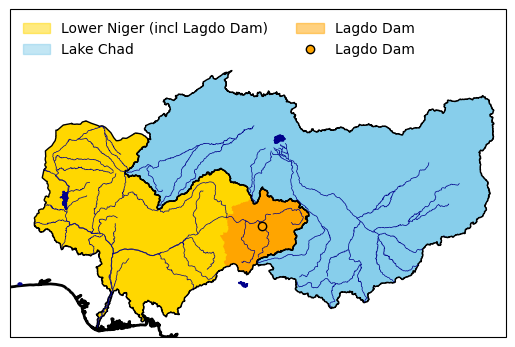

In [15]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)

lower_niger.boundary.plot(ax = ax, color = "k", lw = 1)
lake_chad.boundary.plot(ax = ax, color = "k", lw = 1)
ax.coastlines(lw = 2)

lower_niger.plot(ax = ax, color = "gold")
lake_chad.plot(ax = ax, color = "skyblue")
lagdo_dam.plot(ax = ax, color = "orange")

rv.loc[rv.RIVERS_ID <= 6.0].clip(pd.concat([lower_niger, lake_chad])).plot(ax = ax, color = "darkblue", lw = 0.5)
ax.add_feature(cartopy.feature.LAKES, color = "darkblue")

ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
ax.annotate("Lagdo\nDam", xy = get_latlon("Lagdo Dam").values(), fontweight = "bold", textcoords="offset points", xytext=(5,-8), ha='left')

plt.legend(handles = [matplotlib.patches.Patch(color = c, label = l, alpha = 0.5) for c,l in zip(["gold", "skyblue", "orange"],
                                                                                                 ["Lower Niger (incl Lagdo Dam)", "Lake Chad", "Lagdo Dam"])] + 
           [matplotlib.lines.Line2D([], [], marker = "o", color = "orange", mec = "k", ls = "None", label = "Lagdo Dam")], 
           ncol = 2, edgecolor = "w", loc = "upper left")

ax.set_extent((2,25,4,19))

plt.savefig("study-regions.png")

#### **Elevation**

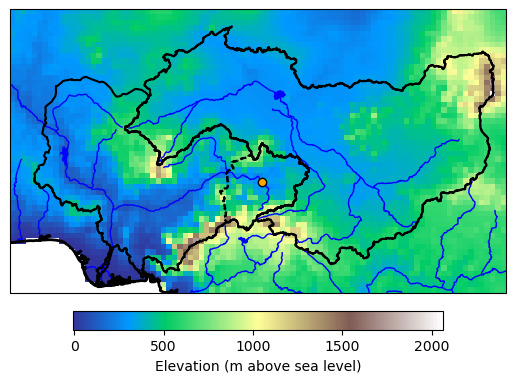

In [18]:
# topography
elev = xr.open_dataset("../90_data/elevation-0.25deg-global.nc").elev

# mask land surface
lsm = regionmask.mask_3D_geopandas(gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev01"), elev.lon, elev.lat, drop = False).squeeze(drop = True)
elev = elev.where(lsm).dropna("lat", "all").dropna("lon", "all").sel(lon = slice(2,25), lat = slice(4,17))

elev.plot(center = False, cmap = "terrain", subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
          cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05, "label" : "Elevation (m above sea level)"})
ax = plt.gcf().axes[0]

lower_niger.boundary.plot(ax = ax, color = "k", lw = 1.5)
lake_chad.boundary.plot(ax = ax, color = "k", lw = 1.5)
lagdo_dam.boundary.plot(ax = ax, color = "k", lw = 1.5, ls = "--")

ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")

ax.add_feature(cartopy.feature.RIVERS, color = "blue")
ax.add_feature(cartopy.feature.LAKES, color = "blue")

ax.coastlines(lw = 2)

plt.savefig("study-regions-topography.png")

#### **Affected regions**

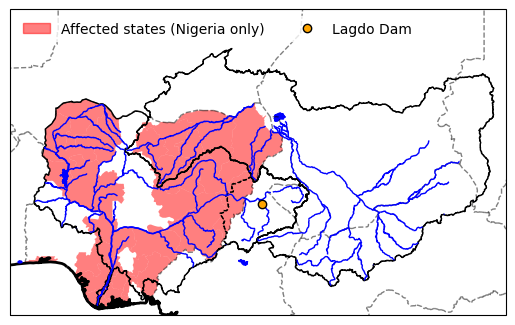

In [20]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)

lower_niger.boundary.plot(ax = ax, color = "k", lw = 1)
lake_chad.boundary.plot(ax = ax, color = "k", lw = 1)
lagdo_dam.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--")
ax.coastlines(lw = 2)

gpd.read_file("00_regions/sf_affected-states").plot(ax = ax, color = "red", alpha = 0.5)

rv.loc[rv.RIVERS_ID <= 6.0].clip(pd.concat([lower_niger, lake_chad])).plot(ax = ax, color = "blue", lw = 1)
ax.add_feature(cartopy.feature.LAKES, color = "blue")
ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)

ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")

plt.legend(handles = [matplotlib.patches.Patch(color = c, label = l, alpha = 0.5) for c,l in zip(["red"], ["Affected states (Nigeria only)"])] + 
           [matplotlib.lines.Line2D([], [], marker = "o", color = "orange", mec = "k", ls = "None", label = "Lagdo Dam")], 
           ncol = 2, edgecolor = "w", loc = "upper left")

ax.set_extent((2,25,4,18))

plt.savefig("study-regions-affected-states.png")

### **Observations**

In [ ]:
chirps = xr.open_dataset("../01_chirps/chirps-daily-p25.nc").precip.sel(longitude = slice(-13,27), latitude = slice(0,25))
tamsat = xr.open_mfdataset("../02_tamsat/tamsat_*_rfe-filled_0.25.v3.1.nc").rfe_filled.sel(lon = slice(-13,27), lat = slice(0,25)).rename(lat = "latitude", lon = "longitude").load()

#### **Daily time series per catchment**

In [4]:
for cmt in ["lake-chad", "lagdo-dam", "lower-niger"]:
    for ds in ["chirps", "tamsat"]:
        
        da = eval(ds)
        da = da.where(regionmask.mask_3D_geopandas(gpd.read_file("00_regions/sf_"+cmt), da.longitude, da.latitude).squeeze(drop = True)).mean(["latitude", "longitude"])
        da.to_netcdf("obs/"+ds+"_"+cmt+"_daily.nc")

#### **Attribution time series**

In [6]:
# methods to compute time series for attribution

def jjas_mean(ts):
    jjas = ts.sel(time = [m in [6,7,8,9] for m in ts.time.dt.month]).resample(time = "AS").mean()
    return jjas

def max_7day(ts):
    ts7 = ts.rolling(time = 7, center = False).mean()
    ts7 = ts7.sel(time = [m in [6,7,8,9] for m in ts7.time.dt.month]).resample(time = "AS").max()
    return ts7

def cx_csv(ts, fnm):
    
    # relabel time dimension & output to csv
    ts.assign_coords(time = ts.time.dt.year).rename(time = "#year").to_dataframe().to_csv(fnm, sep = " ")
    
    # add a line specifying the model & variable name, to be used as filename when uploading
    fnm_string = "# "+ re.sub("\\.txt", "", re.sub(".+/", "", fnm))
    ! echo "$fnm_string" >> $fnm

In [5]:
# Lake Chad: mean JJAS precipitation
for ds in ["chirps", "tamsat"]:
    
    fnm = "obs/"+ds+"_lake-chad_daily.nc"
    ts_jjas = jjas_mean(xr.open_dataset(fnm))
    cx_csv(ts_jjas,  re.sub("daily.nc", "jjas-mean.txt", fnm))

In [6]:
# Lower Niger: annual maximum of 7-day accumulated precipitation
for ds in ["chirps", "tamsat"]:
    
    # load data, select precip variable
    fnm = "obs/"+ds+"_lower-niger_daily.nc"
    ts7 = max_7day(xr.open_dataset(fnm))
    
    cx_csv(ts7, fnm = re.sub("daily.nc", "7day-max.txt", fnm))

#### **Maps of the event definition**

In [10]:
import xarray as xr
import geopandas as gpd
import regionmask
import cartopy

import matplotlib.pyplot as plt


from geopy.geocoders import Nominatim
def get_latlon(city):
    
    # retrieve lat & lon for given location
    location = Nominatim(user_agent="GetLoc").geocode(city)
    if location is None:
        return {"lon" : None, "lat" : None}
    else:
        return {"lon" : location.longitude, "lat" : location.latitude}
    
    
import warnings
warnings.filterwarnings("ignore", message = "facecolor will have no effect.+")                           # ignore warning about change to Cartopy plotting defaults

In [13]:
# load the data & shapefiles
chirps = xr.open_dataset("../01_chirps/chirps-daily-p25.nc").precip.sel(longitude = slice(0,27), latitude = slice(0,20))

sf_niger = gpd.read_file("00_regions/sf_lower-niger")
sf_chad = gpd.read_file("00_regions/sf_lake-chad")

In [15]:
chirps.sel(time = "2022").to_netcdf("chirps_W-Africa.nc")

In [6]:
# compute JJAS mean
chirps_jjas = chirps.sel(time = [m in [6,7,8,9] for m in chirps.time.dt.month]).resample(time = "AS").mean()

# rolling 7-day mean
chirps_7day = chirps.rolling(time = 7, center = False).mean().sel(time = "2022").round(3)

# identify date of heaviest 7-day accumulation across the whole catchment
ln_7day = chirps_7day.where(regionmask.mask_3D_geopandas(gpd.read_file("00_regions/sf_lower-niger"), chirps_7day.longitude, chirps_7day.latitude).squeeze(drop = True)).mean(["latitude", "longitude"])
max7 = ln_7day.idxmax()

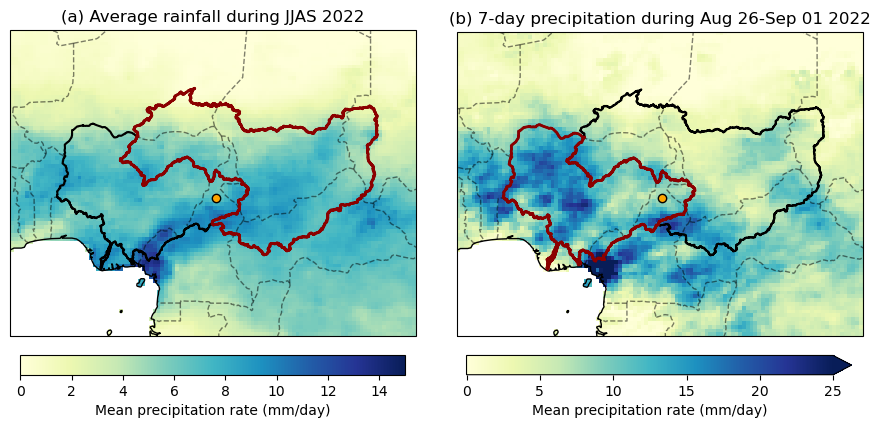

In [11]:
fig, axs = plt.subplots(ncols = 2, dpi = 100, figsize = (11,5), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(wspace = 0.1)
cbar_kw = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05, "label" : "Mean precipitation rate (mm/day)"}

chirps_jjas.sel(time = "2022").plot(ax = axs[0], cmap = "YlGnBu", cbar_kwargs = cbar_kw)
axs[0].set_title("(a) Average rainfall during JJAS 2022")

chirps_7day.sel(time = max7).plot(ax = axs[1], cmap = "YlGnBu", cbar_kwargs = cbar_kw, vmax = 25)
axs[1].set_title("(b) 7-day precipitation during Aug 26-Sep 01 2022")

for ax in axs:
    ax.coastlines()
    sf_chad.boundary.plot(ax = ax, color = "k", lw = 1.5)
    sf_niger.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", color = "k", alpha = 0.5)
    ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
    
sf_chad.boundary.plot(ax = axs[0], color = "darkred", lw = 2)
sf_niger.boundary.plot(ax = axs[1], color = "darkred", lw = 2)

plt.savefig("event-definition-plots_chirps.png")

---
---
## **Additional: decomposing drivers of change**

- if we use global CO2 as the covariate, rather than GMST, how much difference does it make to the fitted model?

In [69]:
co2 = pd.read_csv("../90_data/co2-global.txt", skiprows = 54, sep = " +", engine = "python", index_col = "decimal_date").groupby("year").mean()[["monmean"]]
co2.rename(columns = {"monmean" : "co2"}).to_csv("../90_data/co2-annual.txt")

gmst = xr.open_dataset("../90_data/gmst.nc").Ta.sel(time = slice(None, "2025")).dropna("time", "all")
gmst = gmst.assign_coords(time = gmst.time.dt.year).rename(time = "year").to_dataframe()

gmst.rename(columns = {"Ta" : "gmst"}).to_csv("../90_data/gmst.csv")

In [28]:
erf = pd.read_csv("../90_data/ERF_rcp85_1750-2500.csv", index_col = ["year"])
erf["aerosol"] = erf[[c for c in erf.columns if "aerosol" in c]].sum(axis = 1)

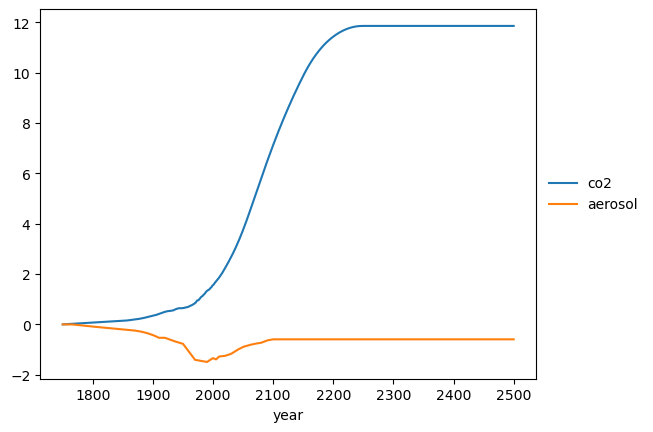

In [29]:
erf[["co2", "aerosol"]].plot()
plt.legend(edgecolor = "w", bbox_to_anchor = (1,0.5), loc = "center left")

In [27]:
erf[[c for c in erf.columns if "aerosol" in c]].sum(axis = 1)

year
1750    0.000000
1751    0.000000
1752    0.000000
1753    0.000000
1754    0.000000
          ...   
2496   -0.593037
2497   -0.593037
2498   -0.593037
2499   -0.593037
2500   -0.593037
Length: 751, dtype: float64